In [1]:
from tqdm import tqdm
from glob import glob
import tifffile
import numpy as np
import os
from EmbedSeg.utils.preprocess_data import extract_data, split_train_val, get_data_properties
from EmbedSeg.utils.generate_crops import *
from EmbedSeg.utils.visualize import visualize_many_crops
import json
from matplotlib.colors import ListedColormap

### Download Data

In [2]:
data_dir = '../../../data'
project_name = 'monuseg-2018'

Ideally, <b>*.tif</b>-type images and the corresponding masks should be respectively present under <b>images</b> and <b>masks</b>, under directories <b>train</b>, <b>val</b> and <b>test</b>, which can be present at any location on your workstation, pointed to by the variable <i>data_dir</i>. (In order to prepare such instance masks, one could use the Fiji plugin <b>Labkit</b> as detailed <b>[here](https://github.com/juglab/EmbedSeg/wiki/Use-Labkit-to-prepare-instance-masks)</b>). The following would be the desired structure as to how data should be present. 

<img src="https://raw.githubusercontent.com/juglab/EmbedSeg/v0.2.4/directory_pngs/png/01_dir_structure.png" width="100"/>

If you already have your data available in the above style, please skip to the <b><a href="#center">third</a></b> section of this notebook, where you specify the kind of center to which constitutive pixels of an object should embed. 
Since for the <b> monuseg-2018</b> dataset, we do not have the data in this format yet, we firstly download the data from an external url in the following cells, next we split this data to create our `train`, `val` and `test` directories. 

The images and corresponding masks are downloaded from an external url, specified by `zip_url` to the path specified by the variables `data_dir` and `project_name`. The following structure is generated after executing the `extract_data` and `split_train_val` methods below:

In [3]:
extract_data(
    zip_url = 'https://github.com/juglab/EmbedSeg/releases/download/v0.1.0/monuseg-2018.zip',
    data_dir = data_dir,
    project_name = project_name,
)

Zip file was downloaded and extracted before!


### Split Data into `train`, `val` \& `test`

Now, we would like to reserve a small fraction (15 % by default) of the provided train dataset as validation data. Here, in case you would like to repeat multiple experiments with the same partition, you may continue and press <kbd>Shift</kbd> + <kbd>Enter</kbd> on the next cell - but in case, you would like different partitions each time, please add the `seed` attribute equal to a different integer (For example, 
```
split_train_val(
data_dir = data_dir, 
project_name = project_name, 
train_val_name = 'train', 
subset = 0.15, 
seed = 1000)
```
)

In [4]:
split_train_val(
    data_dir = data_dir,
    project_name = project_name, 
    train_val_name = 'train',
    subset = 0.15)

Train-Val-Test Images/Masks copied to ../../../data/monuseg-2018


### Specify desired centre location for spatial embedding of pixels

Interior pixels of an object instance can either be embedded at the `medoid`, the `approximate-medoid` or the `centroid`. 

In [3]:
center = 'medoid' # 'medoid', 'approximate-medoid', 'centroid'
try:
    assert center in {'medoid', 'approximate-medoid', 'centroid'}
    print("Spatial Embedding Location chosen as : {}".format(center))
except AssertionError as e:
    e.args += ('Please specify center as one of : {"medoid", "approximate-medoid", "centroid"}', 42)
    raise



Spatial Embedding Location chosen as : medoid


### Calculate some dataset specific properties

In the next cell, we will calculate properties of the data such as `min_object_size`, `foreground_weight` etc. <br>
We will also specify some properties, for example,  
* set `one_hot = True` in case the instances are encoded in a one-hot style. 
* set `data_properties_dir['data_type']='16-bit'` if the images are of datatype `unsigned 16 bit` and 
    `data_properties_dir['data_type']='8-bit'` if the images are of datatype `unsigned 8 bit`.

Lastly, we will save the dictionary `data_properties_dir` in a json file, which we will access in the `02-train` and `03-predict` notebooks.

In [ ]:
one_hot = False
data_properties_dir = get_data_properties(data_dir, project_name, train_val_name=['train', 'val'], 
                                          test_name=['test'], mode='2d', one_hot=one_hot)

data_properties_dir['data_type']='8-bit'

with open('data_properties.json', 'w') as outfile:
    json.dump(data_properties_dir, outfile)
    print("Dataset properies of the `{}` dataset is saved to `data_properties.json`".format(project_name))

### Specify cropping configuration parameters

Images and the corresponding masks are cropped into patches centred around an object instance, which are pre-saved prior to initiating the training. Here, `data_subsets` is a list of names of directories which is processed. Note that the cropped images, masks and center-images would be saved at the path specified by `crops_dir` (The parameter `crops_dir` is set to ```./crops``` by default, which creates a directory at the same location as this notebook). 

In [4]:
def round_up_8(x):
    return (x.astype(int)+7) & (-8)

In [ ]:
crops_dir = './crops'
data_subsets = ['train', 'val'] 
crop_size = np.maximum(round_up_8(data_properties_dir['avg_object_size_y'] + 5*data_properties_dir['stdev_object_size_y']),
round_up_8(data_properties_dir['avg_object_size_x'] + 5*data_properties_dir['stdev_object_size_x']))
print("Crop size in x and y will be set equal to {}".format(crop_size))

### Generate Crops



<div class="alert alert-block alert-warning"> 
    The cropped images and masks are saved at the same-location as the example notebooks. <br>
    Generating the crops would take a little while!
</div>

In [9]:
for data_subset in data_subsets:
    image_dir = os.path.join(data_dir, project_name, data_subset, 'images')
    instance_dir = os.path.join(data_dir, project_name, data_subset, 'masks')
    image_names = sorted(glob(os.path.join(image_dir, '*.tif'))) 
    instance_names = sorted(glob(os.path.join(instance_dir, '*.tif')))  
    for i in tqdm(np.arange(len(image_names))):
        if one_hot:
            process_one_hot(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, crop_size, center, one_hot = one_hot)
        else:
            process(image_names[i], instance_names[i], os.path.join(crops_dir, project_name), data_subset, crop_size, center, one_hot=one_hot)
    print("Cropping of images, instances and centre_images for data_subset = `{}` done!".format(data_subset))

  0%|                                                    | 0/26 [00:00<?, ?it/s]

Created new directory : ./crops/monuseg-2018/train/images/
Created new directory : ./crops/monuseg-2018/train/masks/
Created new directory : ./crops/monuseg-2018/train/center-medoid/


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Cropping of images, instances and centre_images for data_subset = `train` done!
Created new directory : ./crops/monuseg-2018/val/images/
Created new directory : ./crops/monuseg-2018/val/masks/
Created new directory : ./crops/monuseg-2018/val/center-medoid/


100%|████████████████████████████████████████████| 4/4 [06:59<00:00, 104.83s/it]

Cropping of images, instances and centre_images for data_subset = `val` done!


### Visualize cropped images, corresponding ground truth masks and object center images 

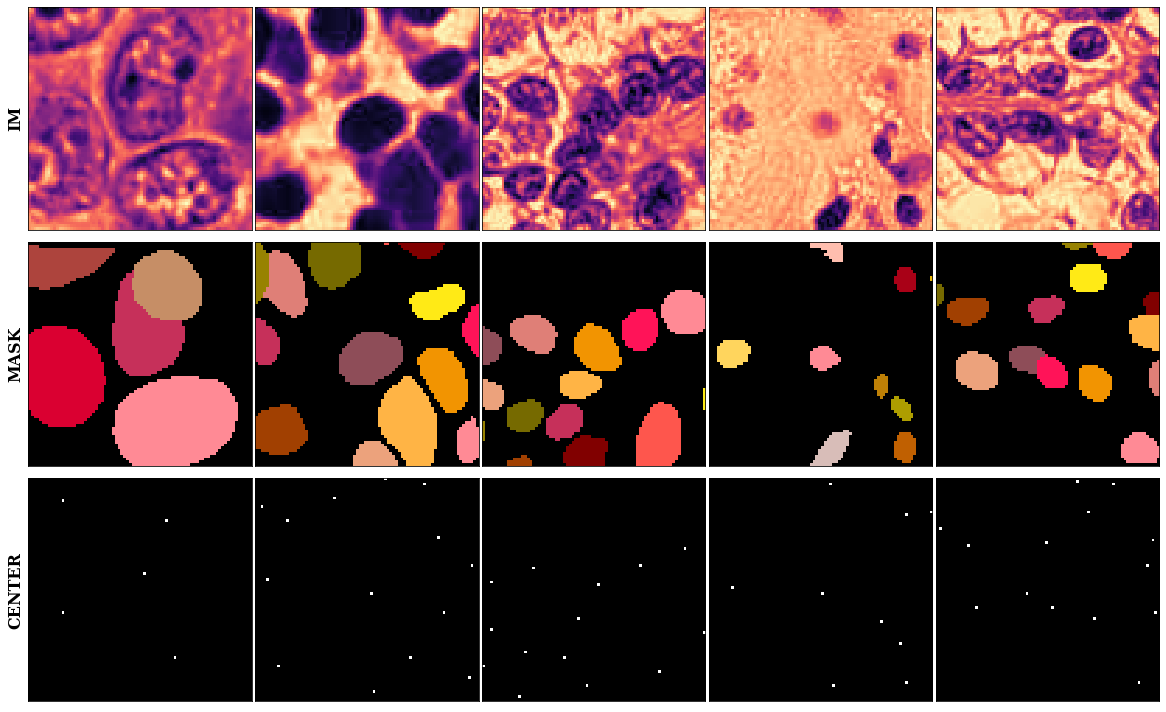

In [6]:
new_cmap = np.load('../../../cmaps/cmap_60.npy')
new_cmap = ListedColormap(new_cmap) # new_cmap = 'magma' would also work! 
visualize_many_crops(data_dir=crops_dir, project_name=project_name, train_val_dir='val', center=center, n_images=5, new_cmp=new_cmap)